In [1]:
### The purpose of this program is to synthesize music files based on their frequencies.
### Steps:
#--> 1. Use Fast Fourier Transformation to convert music from time domain to frequency domain.
#--> 2. Make sure no aliasing takes place (obvious since .wav file samples at 44Khz, Nyquist frequency maintained)
#--> 3. Generate Spectograms.
#--> 4. ML to generate similarity calculations. {Jaccard, Cosine, Euclidean, Manhattan, Dynamic TimeWrap}

In [29]:
from scipy import fft, arange, signal
from scipy.special import logit, expit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import csv
import pandas as pd
from ttictoc import TicToc

In [3]:
folder_root_Hypothesis_1 = "../../Music/hypothesis_1/"
folder_root_Hypothesis_2 = "../../Music/hypothesis_2/"

In [4]:
def read_file(path):
    """
    Reads the audio .wav file and returns the sample rate and data contents of the file.
    """
    sr, signal = wavfile.read(path)
    return sr, signal[:,0]

In [5]:
def read_all(files):
    """Branch audio file extrapolation. Uses read_file() method."""
    ret = []
    t = TicToc()
    t.tic();
    for fl in files:
        ret.append(read_file(fl))
    t.toc();
    print("Time it took to read data from files of length ", len(files), " = ", round(t.elapsed, 3), " seconds.")
    return np.array(ret)

In [6]:
def find_files(PATH, ext):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if ext in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [7]:
music_files = find_files(folder_root_Hypothesis_1, ".wav")

In [8]:
data = read_all(music_files)

Time it took to read data from files of length  7  =  0.298  seconds.


In [9]:
def frequency_sepectrum(sf, x):
    """
    Convertion of Audio from time domain to frequency domain using Fast Fourier Algorithm.
    Parameters:
    1. sf : sampling frequency (usually 44.1 KHz)
    2. x : time domain signals.
    Returns:
    1. Sampling rate.
    2. Frequency distribution (Nyquist maintained)
    """
    x = x - np.average(x)  # biasing.

    n = len(x)
    k = arange(n)
    tarr = n / float(sf)
    frqarr = k / float(tarr)  # two sides frequency range

    frqarr = frqarr[range(n // 2)]  # one side frequency range

    x = fft(x) / n  # fft computing and normalization
    x = x[range(n // 2)]

    return frqarr, abs(x)

In [10]:
def plot(sample_rate, signal, state=False):
    """
    Method responsible for converting from time domain to frequency
    via the discrete fourier analysis function created in frequency_sepectrum().
    Option to form a plot of the resultant frequency domain graph with its frequency content distribution.
    Returns:
    1. Y: The frequencies.
    2. frq: The content distribution.
    """
    frq, Y = frequency_sepectrum(sample_rate, signal)
    frq = frq
    if(state == True):
        plt.plot(frq, Y)
        plt.title("Frequency (Hz) vs. Occurence")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Occurence (Count)")
    return Y, frq

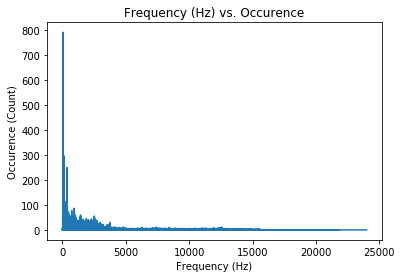

In [11]:
occurence_0, frequencies_0 = plot(data[0][0],data[0][1], True)

In [12]:
occurence_0.argmax(), frequencies_0[9706], occurence_0[occurence_0.argmax()] ## The 50Hz is the fundamental frequency.

(9706, 49.93459781838387, 791.5312547988312)

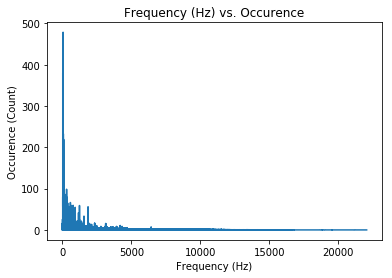

In [13]:
occurence_1, frequencies_1 = plot(data[1][0], data[1][1], True)

In [14]:
occurence_1.argmax(), frequencies_1[occurence_1.argmax()], occurence_1[occurence_1.argmax()] #Fundamental frequency

(14949, 57.37453943777293, 478.4702272066255)

In [15]:
music_files

['../../Music/hypothesis_1/Becky Hill - Sunrise In The East.wav',
 '../../Music/hypothesis_1/Cashmere-CatQuit-ft.-Ariana-GrandeLyrics-_Official-Audio_.wav',
 '../../Music/hypothesis_1/Daya - Insomnia (Lyrics Lyric Video).wav',
 '../../Music/hypothesis_1/Dynoro & Gigi DAgostino - In My Mind.wav',
 '../../Music/hypothesis_1/Maroon-5-Maps-_Lyric-Video_.wav',
 '../../Music/hypothesis_1/Nick-Jonas-_-Nicki-Minaj-Bom-Bidi-Bom-_Lyrics_-_Fifty-Shades-Darker_-HD.wav',
 '../../Music/hypothesis_1/Thinking out Loud.wav']

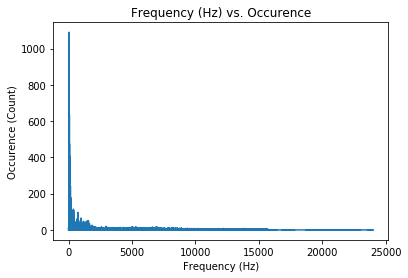

In [16]:
occurence_2, frequencies_2 = plot(data[2][0], data[2][1], True)

In [17]:
occurence_2.argmax(), frequencies_2[occurence_2.argmax()], occurence_2[occurence_2.argmax()] #Fundamental Frequency

(9473, 53.30128641704801, 1090.1268777065009)

In [18]:
frequencies_2[9473*2] / frequencies_2[occurence_2.argmax()],frequencies_2[9473*2], occurence_2[18946] # Second Harmonic

(2.0, 106.60257283409602, 161.64260441587894)

In [19]:
frequencies_2[9473*3] /frequencies_2[occurence_2.argmax()], frequencies_2[9473*3], occurence_2[28419] # Third Harmonic

(3.0, 159.90385925114404, 55.24600306177962)

## Part 2. Discrete Foureir Transformation of EEG Data on Same Music files to check for similarities

In [155]:
folder_data = "../../data/Music/"

In [156]:
brain_music_files = find_files(folder_data, ".csv")

In [157]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        dtx = rows[0].split(",")[3:8]
        cont = []
        for x in dtx:
            cont.append(float(x))
        row_data.append(cont)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [162]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return raw_data, dataframes

In [163]:
brain_data, brain_df = data_DF_dir(brain_music_files)

In [167]:
brain_data[0].shape[0]/128 ## Seconds of Brain Data ~2:43 min.

163.40625

In [62]:
EEG_SAMPLE_RATE = 128 #Emotiv channel sampling rate

In [169]:
brain_data[0]

array([[4224.102539, 4266.666504, 4143.589844, 4121.538574, 4185.128418],
       [4243.589844, 4285.128418, 4174.358887, 4142.563965, 4216.410156],
       [4252.307617, 4298.974121, 4170.256348, 4144.102539, 4226.153809],
       ...,
       [4893.333496, 4295.897461, 4211.794922, 4146.666504, 4252.307617],
       [4867.179688, 4271.282227, 4195.384766, 4135.897461, 4243.589844],
       [4834.871582, 4241.025879, 4168.717773, 4108.205078, 4212.820313]])

In [170]:
def channel_ind_data(data):
    """Retrieves data from each individual channel and splits it into an np.array()"""
    data = data.T
    br_d = []
    for x in data:
        channels = []
        for y in x:
            channels.append(y)
        br_d.append(np.array(channels))
    return np.array(br_d)

In [171]:
EEG_data = channel_ind_data(brain_data[0])

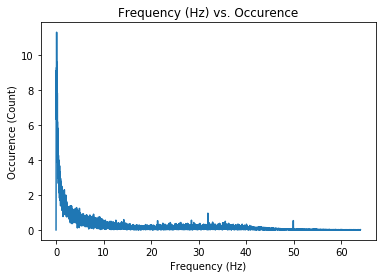

In [332]:
EEG_occ, EEG_freq = plot(EEG_SAMPLE_RATE, EEG_data[1], True)

In [333]:
EEG_occ.argmax(), EEG_freq[EEG_occ.argmax()], EEG_occ[EEG_occ.argmax()] #Fundamental Frequency

(20, 0.12239433926180913, 11.306934467632438)

In [334]:
### Sunrise In the East Maximum Spectral Frequency noted : ~0.1-0.25 Hz

In [335]:
EEG_data_quit = channel_ind_data(brain_data[1])

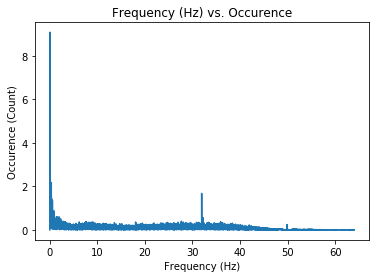

In [336]:
EEG_occ_quit, EEG_freq_quit = plot(EEG_SAMPLE_RATE, EEG_data_quit[1], True)

In [337]:
EEG_occ_quit.argmax(), EEG_freq_quit[EEG_occ_quit.argmax()], EEG_occ_quit[EEG_occ_quit.argmax()] #Fundamental Frequency

(1, 0.003903629155230253, 9.075726819657138)

In [338]:
quit = 57.37453943777293
sunrise = 49.93459781838387
print("Quit / Sunrise in the East : ", str(quit/sunrise), "\nSunrise in the East / Quit : ", str(sunrise/quit))

Quit / Sunrise in the East :  1.1489937226779863 
Sunrise in the East / Quit :  0.8703267739960119


In [339]:
a0 = quit/EEG_freq_quit[EEG_occ_quit.argmax()]

In [340]:
a1 = sunrise/ EEG_freq[EEG_occ.argmax()]

In [330]:
a0,a1,a0/a1,a1/a0 ### Channel 1 Results

(216.14328448581966, 543.9750249840192, 0.39734045601113666, 2.516733408017159)

In [320]:
a0,a1,a0/a1,a1/a0 ### Channel 2 Results

(14697.743345035737,
 407.9812687380145,
 36.02553467834305,
 0.027758089059012787)

In [309]:
a0,a1,a0/a1,a1/a0 ### Channel 3 Results

(524.9194051798478, 543.9750249840192, 0.9649696788841892, 1.036301991536477)

In [297]:
a0,a1,a0/a1,a1/a0 ### Channel 4 Results

(219.36930365724982, 543.9750249840192, 0.4032709105784671, 2.479722622605142)

In [281]:
a0,a1,a0/a1,a1/a0 ### Channel 5 Results

(459.30447953236677, 199.0152530429339, 2.307885815331352, 0.4332969999455655)

In [341]:
(quit*EEG_freq_quit[EEG_occ_quit.argmax()])/(sunrise*EEG_freq[EEG_occ.argmax()])

0.03664585651651839